In [ ]:
# Source => https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/data

In [23]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [24]:
# Useful functions
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [25]:
# Load data
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [29]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values


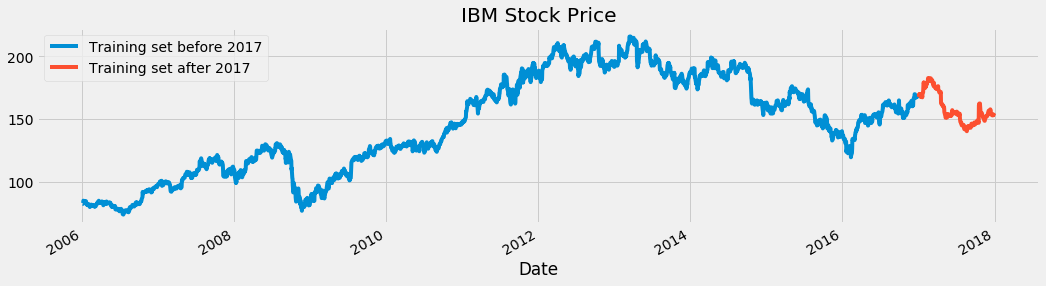

In [30]:
# Visualize the choosen attribute for prices
dataset['High'][:'2016'].plot(figsize=(16,4), legend=True)
dataset['High']['2017':].plot(figsize=(16,4), legend=True)
plt.legend(['Training set before 2017', 'Training set after 2017'])
plt.title('IBM Stock Price')
plt.show()

In [31]:
# Scaling the training set
sc_train = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc_train.fit_transform(training_set)
training_set.shape

(2769, 1)

In [32]:
# Create sequence with 60 timesteps and 1 output 
X_train = []
y_train = []
sequence = 60
for i in range(sequence, 2769): # (60, 2769)
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train

array([[0.06065089, 0.06029868, 0.06311637, ..., 0.0656523 , 0.06656805,
        0.06769513],
       [0.06029868, 0.06311637, 0.0781206 , ..., 0.06656805, 0.06769513,
        0.06875176],
       [0.06311637, 0.0781206 , 0.07262609, ..., 0.06769513, 0.06875176,
        0.06804734],
       ...,
       [0.594745  , 0.59587208, 0.59094111, ..., 0.66420118, 0.65898845,
        0.66244012],
       [0.59587208, 0.59094111, 0.58812342, ..., 0.65898845, 0.66244012,
        0.66074951],
       [0.59094111, 0.58812342, 0.59002536, ..., 0.66244012, 0.66074951,
        0.65546633]])

In [33]:
# Reshape X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.06065089],
        [0.06029868],
        [0.06311637],
        ...,
        [0.0656523 ],
        [0.06656805],
        [0.06769513]],

       [[0.06029868],
        [0.06311637],
        [0.0781206 ],
        ...,
        [0.06656805],
        [0.06769513],
        [0.06875176]],

       [[0.06311637],
        [0.0781206 ],
        [0.07262609],
        ...,
        [0.06769513],
        [0.06875176],
        [0.06804734]],

       ...,

       [[0.594745  ],
        [0.59587208],
        [0.59094111],
        ...,
        [0.66420118],
        [0.65898845],
        [0.66244012]],

       [[0.59587208],
        [0.59094111],
        [0.58812342],
        ...,
        [0.65898845],
        [0.66244012],
        [0.66074951]],

       [[0.59094111],
        [0.58812342],
        [0.59002536],
        ...,
        [0.66244012],
        [0.66074951],
        [0.65546633]]])

In [ ]:
# The LSTM Architecture
model = Sequential()
# First LSTM layer with Dropout regularization
model.add(LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=10, return_sequences=True))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=10, return_sequences=True))
model.add(Dropout(0.2))
# Fourth LSTM layer
model.add(LSTM(units=10))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Fitting to the training set
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
2709/2709 [==============================] - 66s 24ms/step - loss: 0.0538
Epoch 2/20
2709/2709 [==============================] - 72s 26ms/step - loss: 0.0150
Epoch 3/20
2709/2709 [==============================] - 63s 23ms/step - loss: 0.0129
Epoch 4/20
 288/2709 [==>...........................] - ETA: 1:01 - loss: 0.0091

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset['High'][:'2016'], dataset['High']['2017':]), axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(sequence,311): # (60,311)
    X_test.append((inputs[i-60:i,0]))
    print(X_test)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_prices = model.predict(X_test)
predicted_prices = sc.inverse_transform(predicted_prices)

In [ ]:
# Visualizing the predictions from LSTM
plot_predictions(test_set, predicted_prices)

In [ ]:
# Evaluating the LSTM model
return_rmse(test_set, predicted_prices)

In [ ]:
# The GRU Architecture
modelgru = Sequential()
# First GRU layer
modelgru.add(GRU(units=10, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
modelgru.add(Dropout(0.2))
# Second layer
modelgru.add(GRU(units=10, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
modelgru.add(Dropout(0.2))
# Third layer
modelgru.add(GRU(units=10, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
modelgru.add(Dropout(0.2))
# Forth layer
modelgru.add(GRU(units=10, activation='tanh'))
modelgru.add(Dropout(0.2))
# Output layer
modelgru.add(Dense(units=1))
# Compile the GRU model
modelgru.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')
# FItting the GRU model to train data
modelgru.fit(X_train, y_train, epochs=10, batch_size=150)


In [ ]:
# Preparing X_test to predict the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
GRU_predicted_prices = model.predict(X_test)
GRU_predicted_prices = sc.inverse_transform(GRU_predicted_prices)

In [ ]:
# Visualization of the GRU result
plot_predictions(test_set, GRU_predicted_prices)